# Creation and modification of model images for Experiment 2.0

Hello!  This in Matt's quick tutorial on how to create new model images
## Step 1
### Load nessecary modules

In [1]:
# Add python modules
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from copy import deepcopy
# Add parent directory for custom modules
from sys import path as sysPath
sysPath.append('../')
sysPath.append('../Machine_Score/')

# Load custom modules that simr has loaded
import main_SIMR as SIMR
gm = SIMR.gm
im = SIMR.im
SIM = SIMR.SIM
IMG = SIMR.IMG
ms = SIMR.ms
sa = SIMR.sa
dc = SIMR.ms.dc

SIMR.test()
gm.test()
SIM.test()
IMG.test()
ms.test()
dc.test()
sa.test()

SIMR: Hi!  You're in Matthew's main program for all things galaxy collisions
GM: Hi!  You're in Matthew's module for generally useful functions and classes
SM: Hi!  You're in Matthew's main code for all things simulation.
IC: Hi!  You're in Matthew's main code for all things image creation.
MS: Hi!  You're in Matthew's SIMR module for all things machine scoring images
DC: Hi!  You're in direct_image_compare.py
SA: Hi!  You're in Matthew's Main program for score analysis!


___
## Step 2
### Load Target Info class
Needed for loading the target image and running through models later.

In [2]:
tDir = '../targetDir/'
#tDir = '../dataDir/588013383816904792/'
tDir = gm.validPath(tDir)

tInfo = im.target_info_class( targetDir = tDir, printAll=False)
if tInfo.status == False:
    print("WARNING: target info class bad")
else:
    print("Target Good!")
    
# Get run info class
rInfo = tInfo.getRunInfo( )

if rInfo.status == False:
    print("WARNING")
else:
    print("Run '%s' Good!"%rInfo.get('run_id'))

Target Good!
Run 'run_0000' Good!


___
## Step 3
### Load a starting image and image parameter for target
Loading a previous image allows you to start with the correct image size and pixel centers for an associated target image.

{'cmpArg': {'direct_compare_function': 'absolute_difference',
            'targetName': 'zoo_0',
            'targetType': 'target_image',
            'type': 'direct_image_comparison'},
 'comment': 'Starting score parameters '
            'file for '
            '587722984435351614',
 'imgArg': {'comment': 'Starting image '
                       'parameters for '
                       '587722984435351614',
            'galaxy_centers': {'px': 513,
                               'py': 514,
                               'sx': 309,
                               'sy': 608},
            'image_size': {'height': 1024,
                           'width': 1024},
            'name': 'zoo_0'},
 'name': 'zoo_0',
 'scoreType': 'model_fitness_score',
 'simArg': {'nPts': '100k',
            'name': '100k'}}


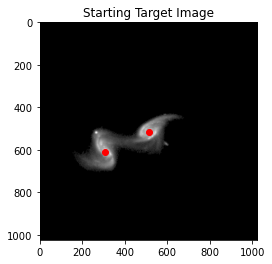

In [3]:
if True: 
    # Change image name if you want to grab a different image parameter
    old_name = 'zoo_0'
    old_params = tInfo.getImageParams(  )
    old_param = old_params[old_name]

    # This image parameter should have the correct size and pixel centers
    gm.pprint( old_param )

    #tInfo.addImageParams( old_param, overWrite = True )

    # Get target image for 
    target_image = tInfo.getTargetImage(old_name)
    plt.imshow(target_image,cmap='gray')
    plt.plot( old_param['imgArg']['galaxy_centers']['px'], old_param['imgArg']['galaxy_centers']['py'], 'ro' )
    plt.plot( old_param['imgArg']['galaxy_centers']['sx'], old_param['imgArg']['galaxy_centers']['sy'], 'ro' )
    plt.title("Starting Target Image")

shift_mat: 
[[1 0 0]
 [0 1 0]
 [0 0 1]]
rot_mat: 
[[ 1.  0.  0.]
 [-0.  1.  0.]]
shift_mat: 
[[   1    0 -150]
 [   0    1 -140]
 [   0    0    1]]
rot_mat: 
[[   1.2    0.  -102.4]
 [  -0.     1.2 -102.4]]


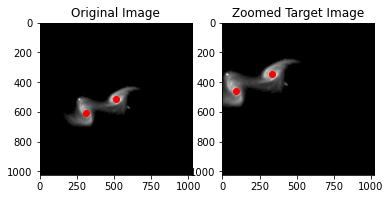

In [4]:
def getNonZeroLimits( image ):
    # Get limit of non-zero pixels of target image
    image_nonzero = image > 0
    image_nonzero = image_nonzero.astype(int)
    x_sums = np.sum( image_nonzero, axis=0 )
    y_sums = np.sum( image_nonzero, axis=1 )

    x_min = np.min( np.where( x_sums > 0 ) )
    x_max = np.max( np.where( x_sums > 0 ) )
    y_min = np.min( np.where( y_sums > 0 ) )
    y_max = np.max( np.where( y_sums > 0 ) )

    print("x_min: %d, x_max: %d, y_min: %d, y_max: %d"%(x_min,x_max,y_min,y_max))
    return x_min, x_max, y_min, y_max
 

def resize_image( image, centers, size = 128 ):
    # Scale down image to size x size
    sImg = cv2.resize( image, (size,size) )
    sCenters = deepcopy(centers)
    sCenters['px'] = round( centers['px'] * size / image.shape[0] )
    sCenters['py'] = round( centers['py'] * size / image.shape[1] )
    sCenters['sx'] = round( centers['sx'] * size / image.shape[0] )
    sCenters['sy'] = round( centers['sy'] * size / image.shape[1] )

    return sImg, sCenters

def shift_rotate_image_with_centers(img, centers, zoom=1, angle=0, coord=None, shift=[0,0], printAll=False ):
    
    # Zoom Image
    cy, cx = [ i/2 for i in img.shape ] if coord is None else coord[::-1]
    shift_mat = np.array( [[1,0,shift[0]], [0,1,shift[1]], [0,0,1]] )
    rot_mat = cv2.getRotationMatrix2D((cx,cy), angle, zoom)
    if printAll: 
        print( "shift_mat: " )
        print( shift_mat )
        print( "rot_mat: " )
        print( rot_mat )

    fin_mat = np.matmul( rot_mat, shift_mat )
    result = cv2.warpAffine(img, fin_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)

    # copy centers into array
    r1 = np.array( [centers['px'], centers['py'], 0 ] )
    r2 = np.array( [centers['sx'], centers['sy'], 0 ] )
    r = np.array( [r1,r2] ).T
    r[0,:] -= centers['px']
    r[1,:] -= centers['py']
    r = np.matmul( fin_mat, r  )
    r[0,:] += centers['px'] + shift[0]*zoom
    r[1,:] += centers['py'] + shift[1]*zoom
    new_centers = { 'px':r[0,0], 'py':r[1,0], 'sx':r[0,1], 'sy':r[1,1] }

    
    return result, new_centers

if True: 
    target_image = tInfo.getTargetImage(old_name)
    t1, c1 = shift_rotate_image_with_centers( target_image, old_param['imgArg']['galaxy_centers'], zoom=1.0, printAll = True )
    t2, c2 = shift_rotate_image_with_centers( target_image, old_param['imgArg']['galaxy_centers'], zoom=1.2, shift = [-150,-140], printAll=True )

    # cImg, new_centers = cropImage( target_image, centers = old_param['imgArg']['galaxy_centers'], scale = 1.1, offset=[0,0] )
    # sImg, new_centers = scaleDownImage( cImg, new_centers, size = 128 )

    # Display both t1 adn t2 images in grayscale
    plt.figure(1)
    plt.subplot(121)
    plt.imshow( t1, cmap='gray' )
    plt.plot( c1['px'], c1['py'], 'ro' )
    plt.plot( c1['sx'], c1['sy'], 'ro' )
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow( t2, cmap='gray' )
    plt.plot( c2['px'], c2['py'], 'ro' )
    plt.plot( c2['sx'], c2['sy'], 'ro' )
    plt.title("Zoomed Target Image")

    # Add circle at center of image
    # plt.plot( new_centers['px'], new_centers['py'], 'ro' )
    # plt.plot( new_centers['sx'], new_centers['sy'], 'ro' )
    # plt.title("Cropped and Scaled Target Image")


___
## Step 4: Create a new image parameter


In [5]:
def createS2Params( tInfo, old_param, new_centers, newName = 'dl-s2-0', printAll = False ):
    # Create a blank group score parameter and copy starting parameters
    new_params = {}
    new_params[newName] = deepcopy( old_param )
    new_params[newName]['comment'] = "Default Parameters Deep-Learning Experiment 2."

    # ALWAYS modify the names
    new_params[newName]['name'] = newName
    new_params[newName]['imgArg']['name'] = newName

    # Leave a comment if its for a specific experiment
    cmt = 'Image for Deep Learning Experiment 2.'
    new_params[newName]['imgArg']['comment'] = cmt

    # Change particle countnew_params[newName]['imgArg']['image_size']['width'] = 50
    new_params[newName]['simArg'] = {'nPts': 4000,
                                    'name': '4k',}

    # If you want to resize the image
    new_params[newName]['imgArg']['image_size']['width'] = 128
    new_params[newName]['imgArg']['image_size']['height'] = 128

    # New Image centers
    new_params[newName]['imgArg']['galaxy_centers'] = new_centers

    # If you want to modify the image blurring affect
    new_params[newName]['imgArg']['blur'] = {}
    new_params[newName]['imgArg']['blur']['type'] = 'gaussian_blur'
    new_params[newName]['imgArg']['blur']['size'] = 13
    new_params[newName]['imgArg']['blur']['weight'] = 0.75

    # If you want to modify the radial brightness constant
    new_params[newName]['imgArg']['radial_const'] = [ 1, 1 ]

    # If you want to modify the final image brightness normalization
    new_params[newName]['imgArg']['normalization'] = {}
    new_params[newName]['imgArg']['normalization']['type'] = 'type1'
    new_params[newName]['imgArg']['normalization']['norm_constant'] = 2.5

    # Make sure scoring methods know to point to new image
    new_params[newName]['cmpArg']['targetName'] = newName
    if printAll: gm.pprint(new_params[newName])

    # Save new parameters
    tInfo.addImageParams( new_params )
    tInfo.saveInfoFile()
    tmp = tInfo.getImageParams().get(newName,None)
    if tmp is None:
        print("ERROR: Failed to save new parameters.")
        return None
    else:
        if printAll: print("Saved new parameters.")
        return new_params

if False:
    new_params = createS2Params( tInfo, old_param, new_centers, printAll = False )
    print( new_params )


In [6]:
if False:
    # Save image to target image directory 
    newName = 'dl-s2-0'
    timgDir = tInfo.get('imgDir')
    print( timgDir )
    print( os.listdir( timgDir ) )
    gm.saveImg( timgDir + 'target_%s.png'%newName, sImg )
    plt.imshow( gm.readImg( timgDir + 'target_%s.png'%newName ), cmap='gray' )

In [7]:
# Gather previous functions here
def createS2Image( tDir=None, tInfo=None, newName = 'dl-s2-0', showImg = False, scale = 1.1, offset=[0,0] ):

    if tInfo == None:
        # Get Target Info
        tInfo = im.target_info_class( tDir ) # Change image name if you want to grab a different image parameter
        if tInfo.status == False:
            return None

    # Get old image parameters
    old_name = 'zoo_0'
    old_params = tInfo.getImageParams(  )
    old_param = old_params[ old_name ]

    # Get target image, crop and rescale
    target_image = tInfo.getTargetImage( old_name )    
    if type(target_image) is type(None):
        print( "Error reading target image." )
        return None

    cImg, new_centers = shift_rotate_image_with_centers( target_image, centers = old_param['imgArg']['galaxy_centers'], zoom = scale, shift=offset )  

    if type(cImg) is type(None):
        print( "Error cropping target image." )
        return None 
    sImg, new_centers = resize_image( cImg, new_centers, size = 128 )

    # Save image to target image directory
    newLoc = tInfo.findTargetImage( tName = newName, newImg=True)
    gm.saveImg( newLoc, sImg )
    fImg = gm.readImg( newLoc )

    # Create new image parameters
    new_params = createS2Params( tInfo, old_param, new_centers, printAll = False )
    if new_params == None:
        print( "Error creating new image parameters." )
        return None
    
    # Show image?
    if showImg: 
        plt.imshow( fImg, cmap='gray' )
        # Add circle at center of image
        plt.plot( new_centers['px'], new_centers['py'], 'ro' )
        plt.plot( new_centers['sx'], new_centers['sy'], 'ro' )
        plt.title( "Cropped and Scaled Target Image\n%s"%tInfo.get('target_id') )
    
    # Create New Image parameters

    return fImg, new_centers
    
#img, cent = createS2Image( tDir = '../targetDir/' )


In [8]:
# Gather training target images
dataDir = '../../spam-data-2022-11/' 

trainTargets = [
    '587739407868690486',
    '587727178988388373',
    '1237678620102623480',
    '587722984435351614',
    '587732136993882121',
    '587734862680752822',
    '587735043609329845',
    '587738569246376675',
    '587741391565422775',
    '587742014353702970',
    '588013383816904792',
    '758877153600208945',
    'hst_Arp_273',
    'hst_ESO_77-14',
    'hst_NGC_6786',
]

mySet = {}

targetImages = []
targetParams = []
for tName in os.listdir(dataDir):
    if tName not in trainTargets: continue
    tDir = os.path.abspath('%s/%s/'%(dataDir,tName))
    if tDir[-1] != '/': tDir += '/'
    tInfo = im.target_info_class( targetDir = tDir, printAll=False ) 
    if tInfo.status == False:
        print("WARNING: target info class bad: tDir: %s"%tDir)
        continue
    
    tImg = tInfo.getTargetImage('zoo_0')
    tParam = tInfo.getImageParams('zoo_0')

    mySet[tName] = { 'img':tImg, 'param':tParam, 'info':tInfo, 'done':False, 'scale':1.0, 'offset':[0,0] }
    #print( tName, type(tImg) )
    # targetImages.append( tImg )
    # targetParams.append( tParam )

mySet['588013383816904792']['scale'] = 1.5
mySet['588013383816904792']['offset'] = [-100,-150]
mySet['588013383816904792']['done'] = True

mySet['hst_NGC_6786']['scale'] = 1.5
mySet['hst_NGC_6786']['offset'] = [150,0]
mySet['hst_NGC_6786']['done'] = True

mySet['hst_Arp_273']['scale'] = 1.4
mySet['hst_Arp_273']['offset'] = [0,-150]
mySet['hst_Arp_273']['done'] = True

mySet['587735043609329845']['scale'] = 1.2
mySet['587735043609329845']['offset'] = [0,-50]
mySet['587735043609329845']['done'] = True

mySet['587722984435351614']['scale'] = 1.7
mySet['587722984435351614']['offset'] = [100,-50]
mySet['587722984435351614']['done'] = True

mySet['587727178988388373']['scale'] = 1.5
mySet['587727178988388373']['offset'] = [50,-100]
mySet['587727178988388373']['done'] = True

mySet['hst_ESO_77-14']['scale'] = 2.4
mySet['hst_ESO_77-14']['offset'] = [0,-50]
mySet['hst_ESO_77-14']['done'] = True

mySet['587732136993882121']['scale'] = 1.5
mySet['587732136993882121']['offset'] = [150,50]
mySet['587732136993882121']['done'] = True

mySet['1237678620102623480']['scale'] = 1.2
mySet['1237678620102623480']['offset'] = [0,0]
mySet['1237678620102623480']['done'] = True

mySet['587734862680752822']['scale'] = 1.2
mySet['587734862680752822']['offset'] = [50,50]
mySet['587734862680752822']['done'] = True

mySet['587741391565422775']['scale'] = 0.9
mySet['587741391565422775']['offset'] = [0,-100]
mySet['587741391565422775']['done'] = True

mySet['587739407868690486']['scale'] = 1.2
mySet['587739407868690486']['offset'] = [0,-50]
mySet['587739407868690486']['done'] = True

mySet['587738569246376675']['scale'] = 1.2
mySet['587738569246376675']['offset'] = [150,-120]
mySet['587738569246376675']['done'] = True

mySet['758877153600208945']['scale'] = 1.3
mySet['758877153600208945']['offset'] = [-50,-50]
mySet['758877153600208945']['done'] = True

mySet['587742014353702970']['scale'] = 1.2
mySet['587742014353702970']['offset'] = [0,125]
mySet['587742014353702970']['done'] = True



588013383816904792
hst_NGC_6786
hst_Arp_273
587735043609329845
587722984435351614
587727178988388373
1237678620102623480
587732136993882121
hst_ESO_77-14
587734862680752822
758877153600208945
587738569246376675
587739407868690486
587741391565422775
587742014353702970


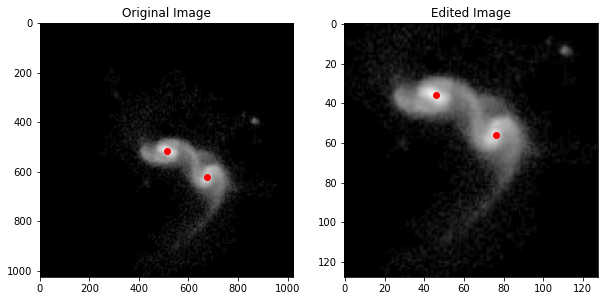

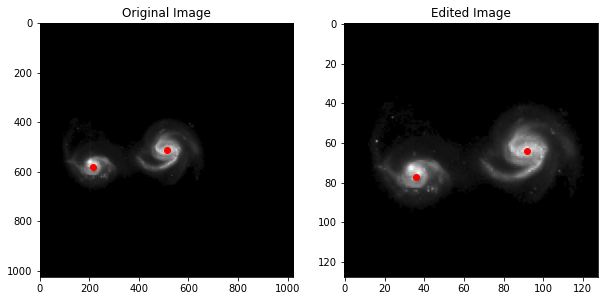

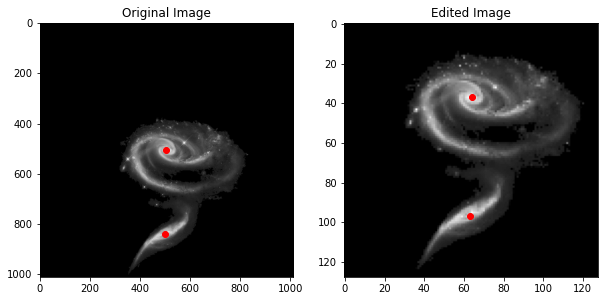

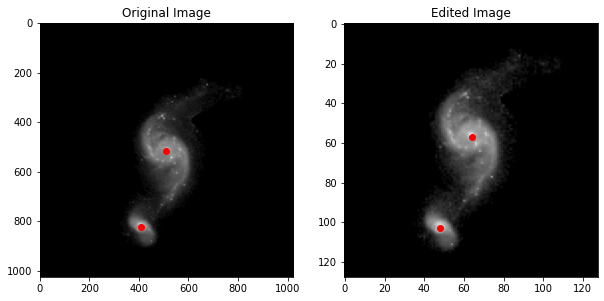

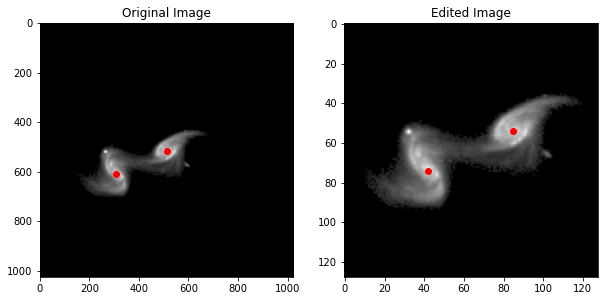

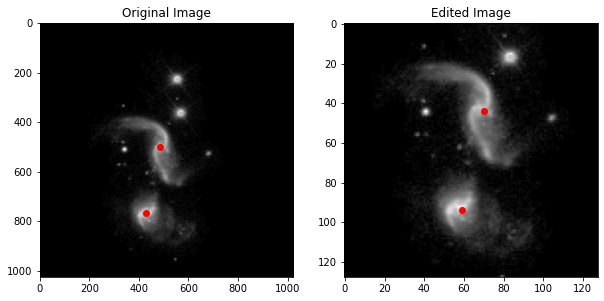

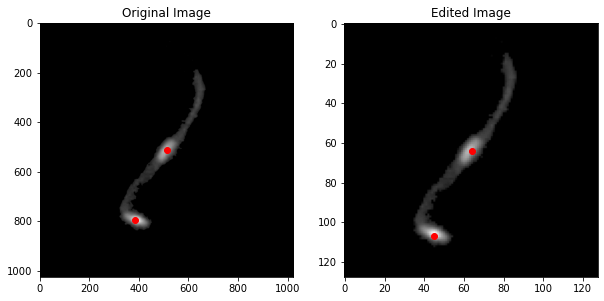

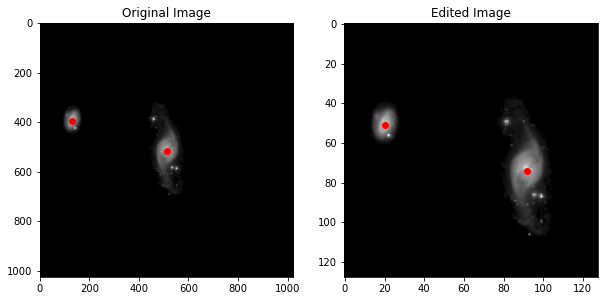

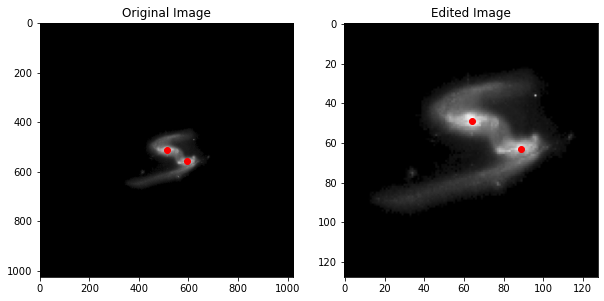

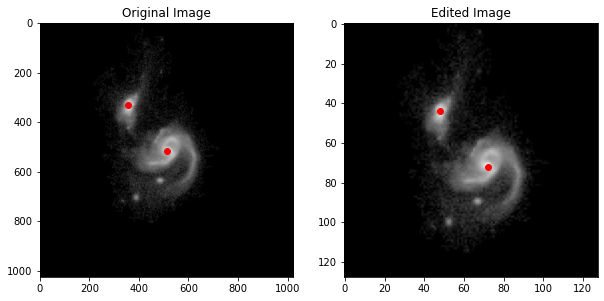

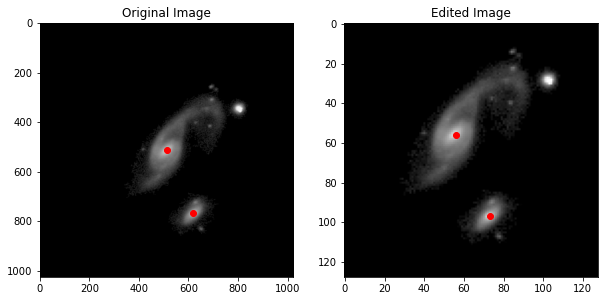

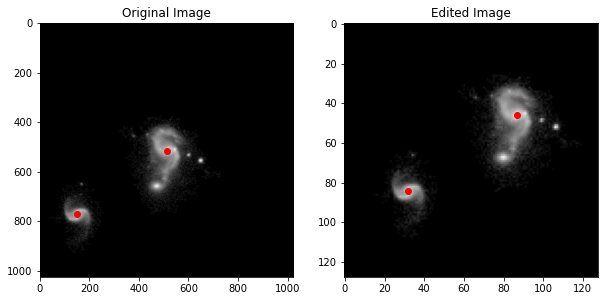

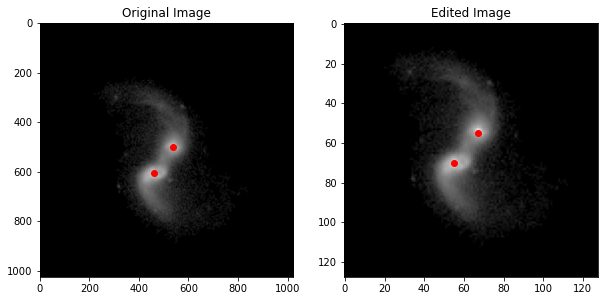

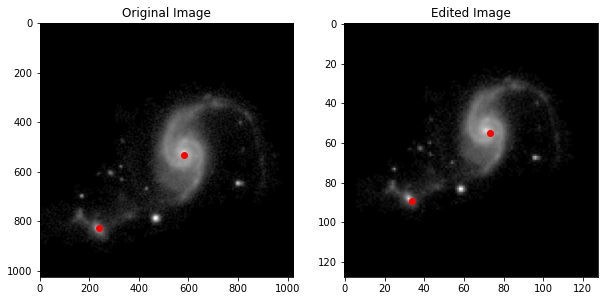

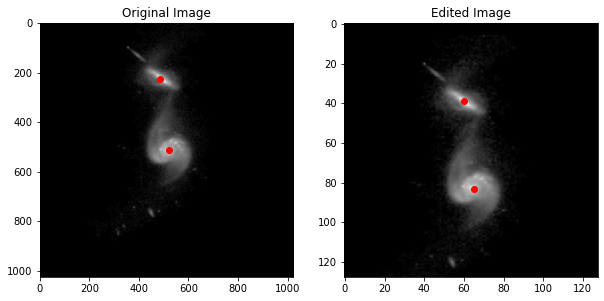

In [9]:

for tName in mySet:
    #if mySet[tName]['done']: continue
    print( tName )
    tInfo = mySet[tName]['info']
    tImg = mySet[tName]['img']
    tCenters = mySet[tName]['param']['imgArg']['galaxy_centers']    
    sImg, sCenters = createS2Image( tInfo = tInfo, scale = mySet[tName]['scale'], offset = mySet[tName]['offset'] )

    tInfo.saveTargetImage( sImg, 'dl-s2-0' )
    
    # Display both images in grayscale
    plt.figure( figsize=(10,10) )
    plt.subplot(1,2,1)
    plt.imshow( tImg, cmap='gray' )
    plt.plot( [ tCenters['px'], tCenters['sx']] , [ tCenters['py'], tCenters['sy'] ], 'ro' )
    plt.title( "Original Image" )
    plt.subplot(1,2,2)
    plt.imshow( sImg, cmap='gray' )
    plt.plot( [ sCenters['px'], sCenters['sx']] , [ sCenters['py'], sCenters['sy'] ], 'ro' )
    plt.title( "Edited Image" )

    



In [10]:
imgList = []
for tName in mySet:
    if tName == 'ex': continue
    tDir = dataDir + tName + '/'
    tInfo = im.target_info_class( targetDir = tDir, printAll=False )
    tImg1 = tInfo.getTargetImage('zoo_0')
    tImg2 = tInfo.getTargetImage('dl-s2-0')
    print( tName, tImg1.shape, tImg2.shape )
    imgList.append( tImg1 )
    imgList.append( tImg2 )


588013383816904792 (1024, 1024) (128, 128)
hst_NGC_6786 (1024, 1024) (128, 128)
hst_Arp_273 (1012, 1012) (128, 128)
587735043609329845 (1024, 1024) (128, 128)
587722984435351614 (1024, 1024) (128, 128)
587727178988388373 (1024, 1024) (128, 128)
1237678620102623480 (1024, 1024) (128, 128)
587732136993882121 (1024, 1024) (128, 128)
hst_ESO_77-14 (1024, 1024) (128, 128)
587734862680752822 (1024, 1024) (128, 128)
758877153600208945 (1024, 1024) (128, 128)
587738569246376675 (1024, 1024) (128, 128)
587739407868690486 (1024, 1024) (128, 128)
587741391565422775 (1024, 1024) (128, 128)
587742014353702970 (1024, 1024) (128, 128)


In [11]:
def showImgList( imgList, titleList = None, col_count=4, cmap='gray', size = 12 ):
    
    n = len( imgList )
    from math import ceil
    
    row_count = ceil( n / col_count )
    
    # Assuming square images
    width = size
    height = int( width * ( row_count / col_count ) )
    
    # Create title list if not given
    if titleList == None:
        titleList = range( n )
    
    # Initialize figure
    fig, ax = plt.subplots( row_count, col_count, figsize=(width,height) )
    
    ri, ci = 0, 0
    for i, img in enumerate( imgList ):
    
        pass
        ax[ri,ci].set_title( titleList[i] )
        
        # Only show if valid image
        if type(img) != type(None): ax[ri,ci].imshow( imgList[i] , cmap=cmap )
        
        # Iterate indices
        ci += 1
        if ci >= col_count:
            ci = 0
            ri += 1

#showImgList( timgList, titleList, size = 18 )

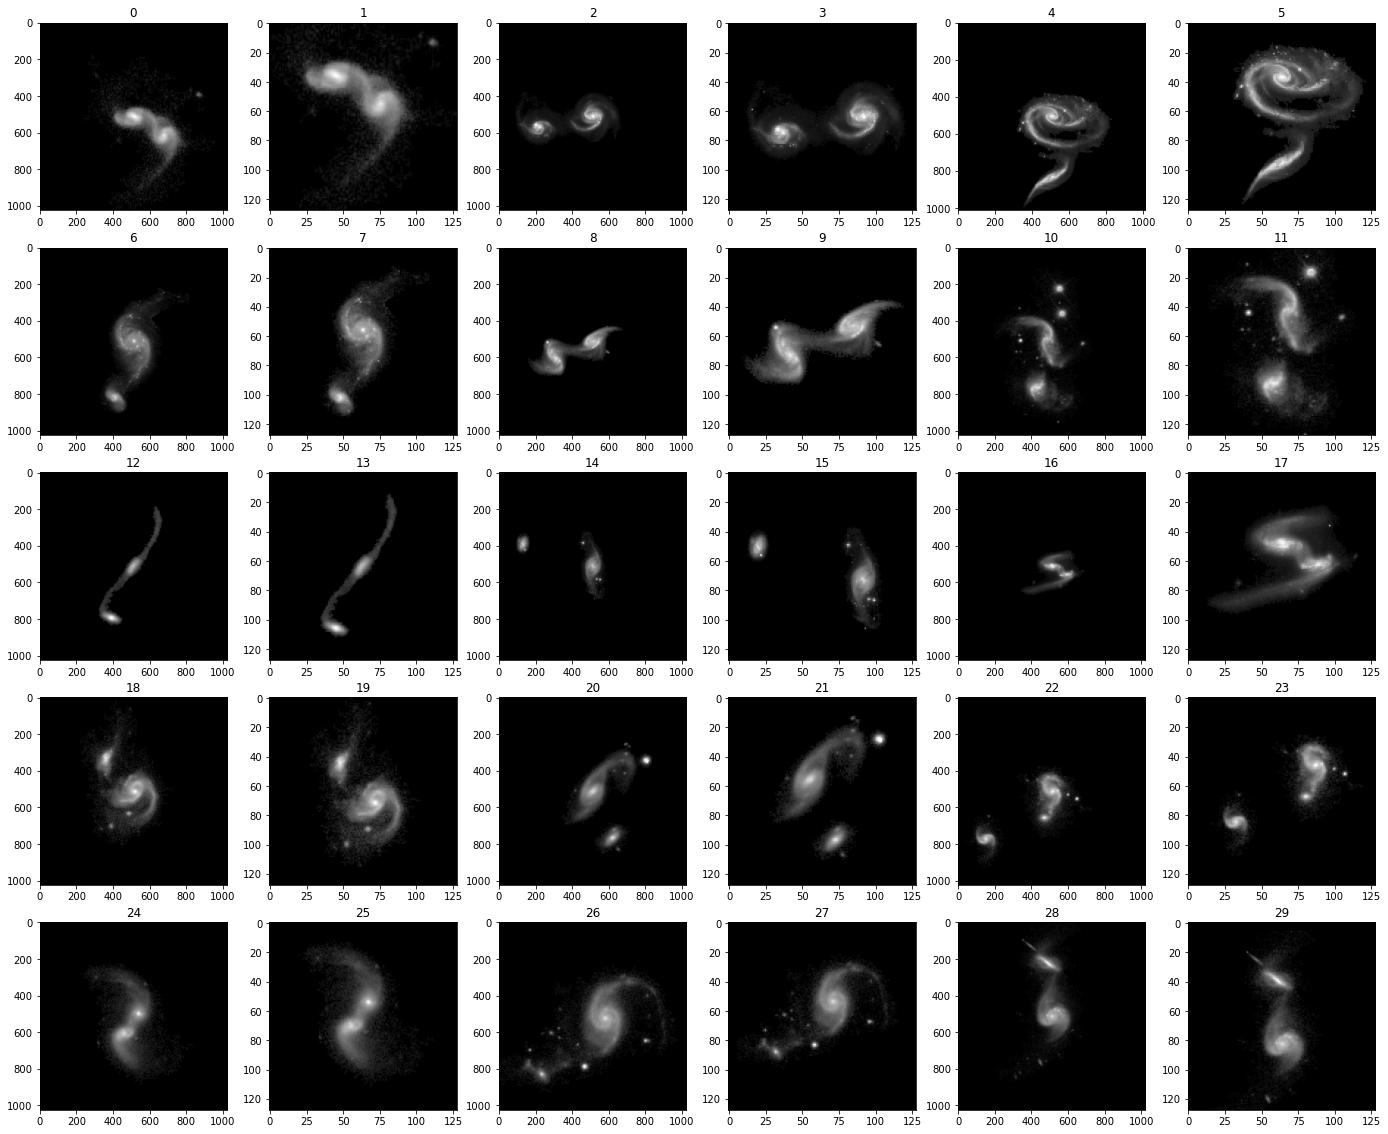

In [12]:
showImgList( imgList, col_count=6, size = 24 )

___
## Step 5
### Test if SIMR pipeline can create the new model image!

{'dl-s2-0': {'cmpArg': {'direct_compare_function': 'absolute_difference',
                        'targetName': 'dl-s2-0',
                        'targetType': 'target_image',
                        'type': 'direct_image_comparison'},
             'comment': 'Default '
                        'Parameters '
                        'Deep-Learning '
                        'Experiment 2.',
             'imgArg': {'blur': {'size': 13,
                                 'type': 'gaussian_blur',
                                 'weight': 0.75},
                        'comment': 'Image '
                                   'for '
                                   'Deep '
                                   'Learning '
                                   'Experiment '
                                   '2.',
                        'galaxy_centers': {'px': 65,
                                           'py': 64,
                                           'sx': 60,
                              

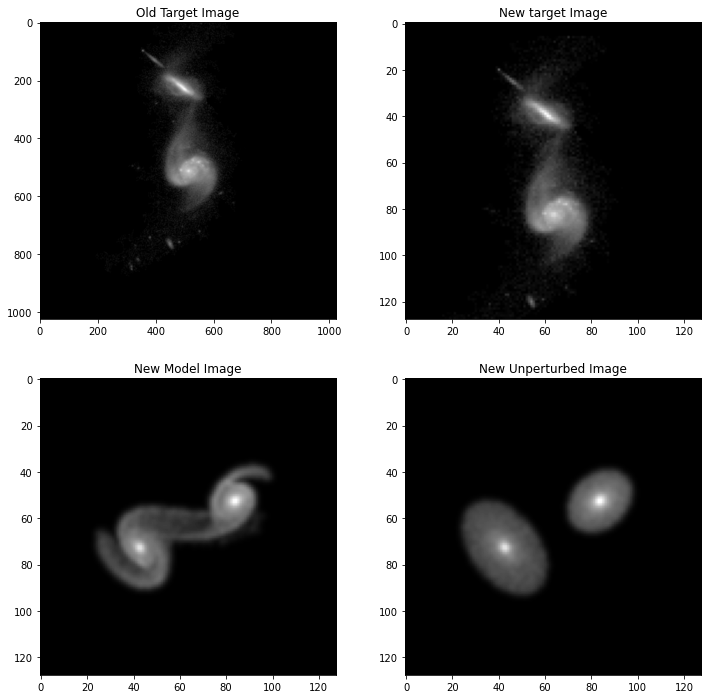

In [13]:
if True: 
    # Get run info class
    new_params = tInfo.getImageParams()
    gm.pprint( new_params )
    newName = 'dl-s2-0'

    new_params = { newName: new_params[newName] }

    new_params[newName]['simArg']['nPts'] = 10000
    new_params[newName]['simArg']['name'] = '10k'
    new_params[newName]['imgArg']['blur']['size'] = 13
    new_params[newName]['imgArg']['blur']['weight'] = 1
    new_params[newName]['imgArg']['radial_const'] = [ 0.25, .25 ]

    # Define arguments for executing simr
    newImgArg = gm.inArgClass( )
    newImgArg.setArg( 'rInfo', rInfo )  # Give rInfo
    # newImgArg.setArg( 'scoreParams', new_params )  # Give new parameter
    # newImgArg.setArg( 'scoreParamName', 'dl-s2-0' )  # Give new parameter

    newImgArg.setArg( 'printAll', True )  # Print all if you need to troubleshoot
    # newImgArg.setArg( 'newSim', True )  # Make true if you want new image
    # newImgArg.setArg( 'zipSim', True )  # Make sure it can create a new score as well.
    newImgArg.setArg( 'newImage', True )  # Make true if you want new image
    # newImgArg.setArg( 'newScore', True )  # Make sure it can create a new score as well.
    newImgArg.setArg( 'overWrite', True )  # Make true if you need to overwrite
    # newImgArg.setArg( 'newTargetImage', True )  # Make true if you need to overwrite

    # Run through simr image creation
    SIMR.run_new_score( rInfo=rInfo, cmdArg = newImgArg )
    rInfo.printScores(allScores=True)

    # View new model image next to target image
    tImg0 = tInfo.getTargetImage(old_param['cmpArg']['targetName'])
    tImg = tInfo.getTargetImage( newName )

    mImg = rInfo.getModelImage( newName )
    iImg = rInfo.getModelImage( newName, imgType='init' )

    if type( mImg ) == type(None) or type( tImg ) == type(None) or type( iImg ) == type( None) or type( tImg0 ) == type( None):
        print( "Error: One of the images is None" )
        print( "tImg0: ", type( tImg0 ) )
        print( "tImg: ", type( tImg ) )
        print( "mImg: ", type( mImg ) )
        print( "iImg: ", type( iImg ) )
        

    else:
        fig, ax = plt.subplots(2,2,figsize=(12,12))

        ax[0,0].set_title("Old Target Image")
        ax[0,0].imshow( tImg0, cmap='gray' )

        ax[0,1].set_title("New target Image")
        ax[0,1].imshow( tImg, cmap='gray' )

        ax[1,0].set_title("New Model Image")
        ax[1,0].imshow( mImg,cmap='gray')

        ax[1,1].set_title("New Unperturbed Image")
        ax[1,1].imshow( iImg, cmap='gray' )

___
## Step 6
### Save your new image parameters!

## Step 7: Create script to test second target

In [14]:
def buildPyCmd( cmdArg ):
    
    # initialize cmd
    cmd = 'python3 main_SIMR.py'
    
    # Most common arguments I would use in command line
    
    printArg = [ 'printBase', 'printAll', 'printRunBase', 'printRunAll' ]
    dirArg   = [ 'runDir', 'targetDir', 'dataDir' ]
    paramArg = [ 'scoreParamLoc', 'scoreParamName', ]
    simrArg  = [ 'newSim', 'zipSim', 'newImage', 'newScore', 'newTargetImage', 'overWrite' ]
    newArg   = [ 'newInfo', 'newBase', 'newRunInfo', 'newRunBase' ]
    iterArg  = [ 'startRun', 'endRun', 'skipRun' ]
    
    # T/F Print args
    for p in printArg:
        val = cmdArg.get( p, None )
        if val != None: cmd += ' -%s %s' % (p, val)
    
    # Str directories
    for d in dirArg:
        val = cmdArg.get( d, None )
        if val != None: cmd += ' -%s %s' % (d, val)
        
    #Parameter Args
    for p in paramArg:
        val = cmdArg.get( p, None )
        if val != None: cmd += ' -%s %s' % (p, val)
    
        
    # Str directories
    for s in simrArg:
        val = cmdArg.get( s, None )
        if val != None: cmd += ' -%s %s' % (s, val)
        
    # New target/runs
    for n in newArg:
        val = cmdArg.get( n, None )
        if val != None: cmd += ' -%s %s' % (n, val)
        
    # iter Args
    for i in iterArg:
        val = cmdArg.get( i, None )
        if val != None: cmd += ' -%s %s' % (i, val)
        
    # End an end line
    
    cmd += '\n'
    return cmd 

# Define arguments for executing simr
testArg = gm.inArgClass( )
testArg.setArg( 'targetDir', 'testDir'  )  # Give rInfo
testArg.setArg( 'scoreParamName', 'dl-s2-0' )  # Give new parameter
testArg.setArg( 'printAll', True )  # Print all if you need to troubleshoot
testArg.setArg( 'newTargetImage', True )  # Have Target create a corresponding image

pyCmd = buildPyCmd( testArg ) 
print( pyCmd )

# Define arguments for executing simr
testArg = gm.inArgClass( )
testArg.setArg( 'targetDir', 'testDir'  )  # Give rInfo
testArg.setArg( 'scoreParamName', 'dl-s2-0' )  # Give new parameter
testArg.setArg( 'newTargetImage', True )  # Have Target create a corresponding image
testArg.setArg( 'printAll', True )  # Print all if you need to troubleshoot
testArg.setArg( 'printRunBase', True )  # Print all if you need to troubleshoot
testArg.setArg( 'newSim', True )  # Make true if you want new image
testArg.setArg( 'zipSim', True )  # ZIp up particles you create for imaging later
testArg.setArg( 'newImage', True )  # Make true if you want new image
testArg.setArg( 'newScore', True )  # Make sure it can create a new score as well.
testArg.setArg( 'overWrite', True )  # Make true if you need to overwrite
testArg.setArg( 'startRun', 0 )  # Print a few for troubleshooting
testArg.setArg( 'endRun', 1 ) 

# Run through simr image creation
#simr.run_new_score( rInfo=rInfo, cmdArg = testArg )


pyCmd = buildPyCmd( testArg ) 
print( pyCmd )


python3 main_SIMR.py -printBase True -printAll True -targetDir testDir -scoreParamName dl-s2-0 -newTargetImage True

python3 main_SIMR.py -printBase True -printAll True -printRunBase True -targetDir testDir -scoreParamName dl-s2-0 -newSim True -zipSim True -newImage True -newScore True -newTargetImage True -overWrite True -startRun 0 -endRun 1



## Step 8: Create slurm scripts for babbage

In [18]:

test_params = {}
test_params['dl-test-s2-0'] = gm.deepcopy( new_params['dl-s2-0'] )
test_params['dl-test-s2-0']['name'] = 'dl-test-s2-0'
test_params['dl-test-s2-0']['cmpArg']['targetName'] = 'dl-test-s2-0'
test_params['dl-test-s2-0']['imgArg']['name'] = 'dl-test-s2-0'
gm.pprint(test_params)




{'dl-test-s2-0': {'cmpArg': {'direct_compare_function': 'absolute_difference',
                             'targetName': 'dl-test-s2-0',
                             'targetType': 'target_image',
                             'type': 'direct_image_comparison'},
                  'comment': 'Default '
                             'Parameters '
                             'Deep-Learning '
                             'Experiment '
                             '2.',
                  'imgArg': {'blur': {'size': 13,
                                      'type': 'gaussian_blur',
                                      'weight': 1},
                             'comment': 'Image '
                                        'for '
                                        'Deep '
                                        'Learning '
                                        'Experiment '
                                        '2.',
                             'galaxy_centers': {'px': 65,
            

In [21]:
print( trainTargets )

def buildBabCmd( pyCmd, name = 'test_babbage', cores = 4 ):
    
    cmd += 'cd galaxyJSPAM/ \n'
    cmd += 'source simr_env/bin/activate \n\n'
    cmd += 'mpirun -n $NSLOTS %s \n' % pyCmd
    
    return cmd

expDir = '../Experiments/dl-s2-0/'

def createQueue( expDir, name='' ):
    
    # Define testing arguments
    testArg = gm.inArgClass( )
    testArg.setArg( 'targetDir', 'testDir/' )  # Give target directory
    testArg.setArg( 'scoreParamLoc', 'param/dl-s2-0.json' )  # Give new parameter
    testArg.setArg( 'newTargetImage', True )  # Have Target create a corresponding image
    testArg.setArg( 'printAll', True )  # Print all if you need to troubleshoot
    testArg.setArg( 'printRunBase', True )  # Print all if you need to troubleshoot
    testArg.setArg( 'newSim', True )  # Make true if you want new image
    testArg.setArg( 'zipSim', True )  # Make sure it can create a new score as well.
    testArg.setArg( 'newImage', True )  # Make true if you want new image
    testArg.setArg( 'newScore', True )  # Make sure it can create a new score as well.
    testArg.setArg( 'startRun', 0 )
    testArg.setArg( 'endRun', 8 )
    
    pyCmd = buildPyCmd( testArg ) 
    babCmd = buildBabCmd( pyCmd, name='test_%s'%name, cores = 4 )
        
    testLoc = expDir + 'test.qsub'
    tFile = open( testLoc, 'w' )
    tFile.write( babCmd )
    tFile.close()
    
    print("\n" + "##############   TEST   ##################\n" )
    print( babCmd )
    


    # Define arguments for executing new run
    newImgArg = gm.inArgClass( )
    newImgArg.setArg( 'scoreParamLoc', 'param/dl-s2-0.json' )  # Give new parameter
    newImgArg.setArg( 'newTargetImage', True )  # Have Target create a corresponding image
    newImgArg.setArg( 'printAll', True )  # Print all if you need to troubleshoot
    newImgArg.setArg( 'printBase', True )  # Print all if you need to troubleshoot
    newImgArg.setArg( 'newSim', True )  # Make true if you want new image
    newImgArg.setArg( 'zipSim', True )  # Make sure it can create a new score as well.
    newImgArg.setArg( 'newImage', True )  # Make true if you want new image
    newImgArg.setArg( 'newScore', False )  # Make sure it can create a new score as well.

    for i,t in enumerate(tNames):
        
        newImgArg.setArg( 'targetDir', 'dataDir/%s/' % t )
        
        pyCmd = buildPyCmd( newImgArg )
        
        babCmd = buildBabCmd( pyCmd, name='%s_%s' % (name, t) )
    
        qLoc = expDir + '%s.qsub' % t
        qFile = open( qLoc, 'w' )
        qFile.write( babCmd )
        qFile.close()
        
        if i < 2: 
            print("\n" + "##############   %s   ##################\n"%t )
            print( babCmd )
    
createQueue(expDir, name = 'dl-s2-0')

NameError: name 'buildBabCmd' is not defined

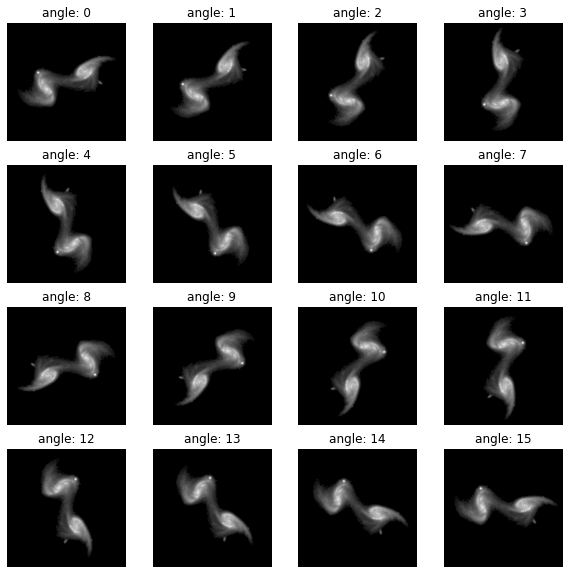

In [ ]:
import cv2, imutils
# Get 16 different orientations of croppped image
rotated_images = []
for i in range(16):
    angle = i * 22.5
    rotated = imutils.rotate( cImg, angle )
    rotated_images.append( rotated )

# plot all 16 images
fig, ax = plt.subplots(4,4,figsize=(10,10))
for i in range(4): 
    for j in range(4):
        ax[i,j].imshow(rotated_images[i*4+j],cmap='gray')
        ax[i,j].set_title("angle: %d"%(i*4+j))
        ax[i,j].axis('off')
    


## Step 7: Apply to all targets? 

In [ ]:
dDir = '../dataDir/'

tNames = os.listdir( dDir )
tNames.sort()

imgs = []
names = []


for t in tNames:
    
    tDir = dDir + t
    
    tinfo = im.target_info_class( tDir )
    
    timg = tinfo.getTargetImage( 'dl-s1-0' )
    
    imgs.append(timg)
    names.append(t)
    
    print( t, type( timg ) )

1237678620102623480 <class 'numpy.ndarray'>
587722984435351614 <class 'numpy.ndarray'>
587724234257137777 <class 'numpy.ndarray'>
587726033843585146 <class 'numpy.ndarray'>
587727177926508595 <class 'numpy.ndarray'>
587727178988388373 <class 'numpy.ndarray'>
587727222471131318 <class 'numpy.ndarray'>
587728676861051075 <class 'numpy.ndarray'>
587729227151704160 <class 'numpy.ndarray'>
587731913110650988 <class 'numpy.ndarray'>
587732136993882121 <class 'numpy.ndarray'>
587732772130652231 <class 'numpy.ndarray'>
587733080814583863 <class 'numpy.ndarray'>
587734862680752822 <class 'numpy.ndarray'>
587735043609329845 <class 'numpy.ndarray'>
587735665840881790 <class 'numpy.ndarray'>
587736523764334706 <class 'numpy.ndarray'>
587736941981466667 <class 'numpy.ndarray'>
587738569246376675 <class 'numpy.ndarray'>
587738569249390718 <class 'numpy.ndarray'>
587739153356095531 <class 'numpy.ndarray'>
587739407868690486 <class 'numpy.ndarray'>
587739505541578866 <class 'numpy.ndarray'>
5877396467

In [ ]:
testTargets = [
    '587739407868690486',
    '587727178988388373',
]

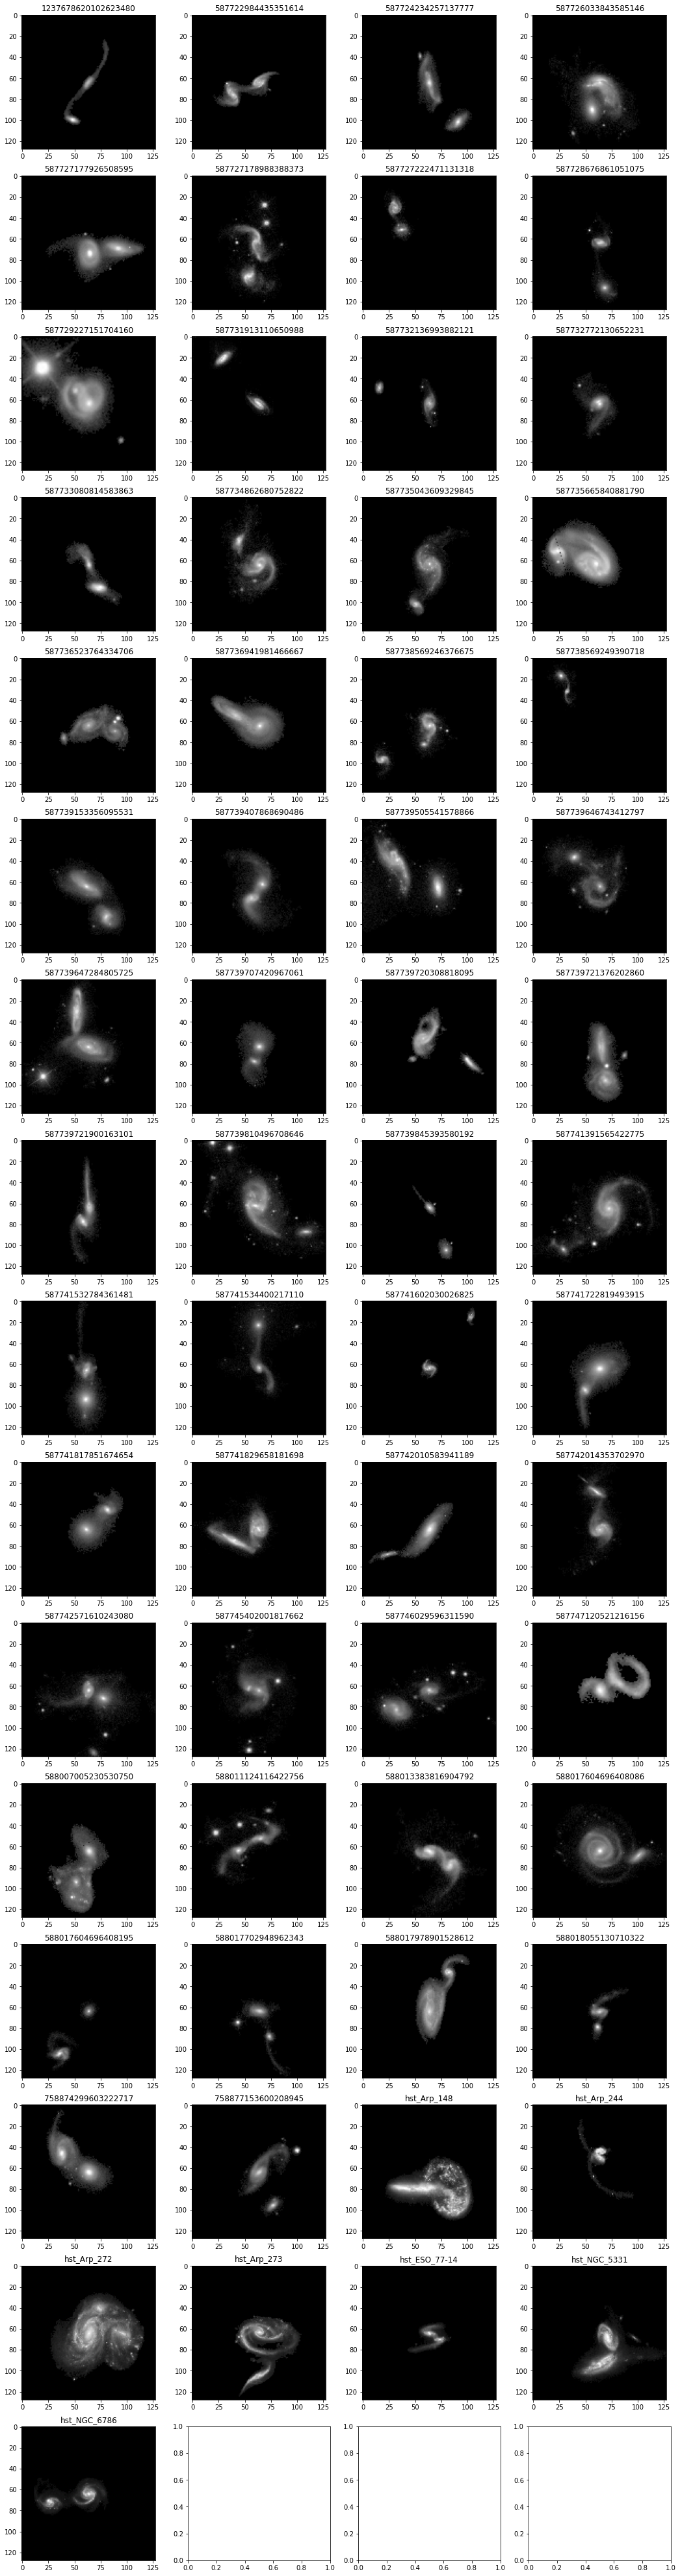

In [ ]:
showImgList( imgs, names, size = 18 )